In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import collections
from IPython import display
import import_ipynb
from util import utils

# 环境

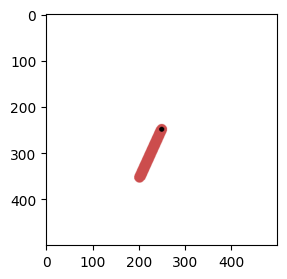

In [2]:
env = utils.PendulumEnv()
env.reset()
env.show()

# 算法定义

## 策略网络

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound

## 价值网络

In [4]:
class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) # 拼接状态和动作
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

## DDPG类

In [5]:
class DDPG:
    ''' DDPG算法 '''
    name = 'DDPG'
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states, self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

    def play(self, env, update=False, show=False, replay_buffer=None):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_return += reward
            if show:
                display.clear_output(wait=True)
                env.show()
            if update:
                # 当 buffer数据的数量超过一定值后，才更新网络
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
        return episode_return   

# 初始化

In [6]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [7]:
buffer_size = 10000
batch_size = 64
minimal_size = 500
replay_buffer = utils.ReplayBuffer(buffer_size)

In [8]:
state_dim = env.observation_space.shape[0]
hidden_dim = 64
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
sigma = 0.01  # 高斯噪声标准差
actor_lr = 3e-4
critic_lr = 3e-3
tau = 0.005  # 软更新参数
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

In [9]:
num_episodes = 200
epochs = 10

# 玩一局游戏（训练前）

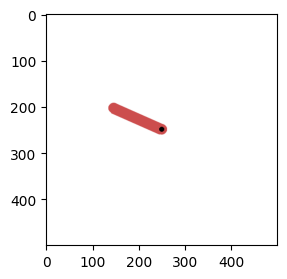

回报：71.50421159069398


In [10]:
episode_return = agent.play(env, update=False, show=True, replay_buffer=replay_buffer)
print("回报：{}".format(episode_return))

# 算法训练

## 训练过程

In [11]:
def train(env, agent, num_episodes, epochs, replay_buffer=None):
    return_list = [] # 记录每一条序列的回报
    update = True
    show = False
    for i in range(epochs): # 显示epochs个进度条
        with tqdm(total=int(num_episodes / epochs), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / epochs)):  # 每个进度条的序列数
                episode_return = agent.play(env, update, show, replay_buffer)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

In [12]:
return_list = train(env=env, agent=agent, num_episodes=num_episodes, epochs=epochs, replay_buffer=replay_buffer)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5552\262774100.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
Iteration 9: 100%|████████████████████████████████████████| 20/20 [00:47<00:00,  2.38s/it, episode=200, return=179.760]


## 训练结果

### 训练回报

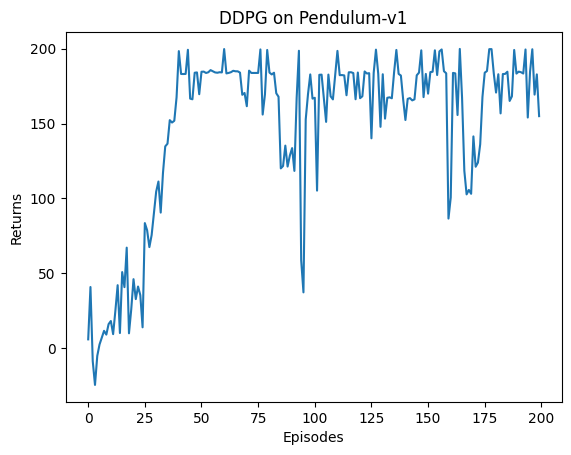

In [13]:
utils.show_return(return_list, agent, env)

### 移动平均训练回报

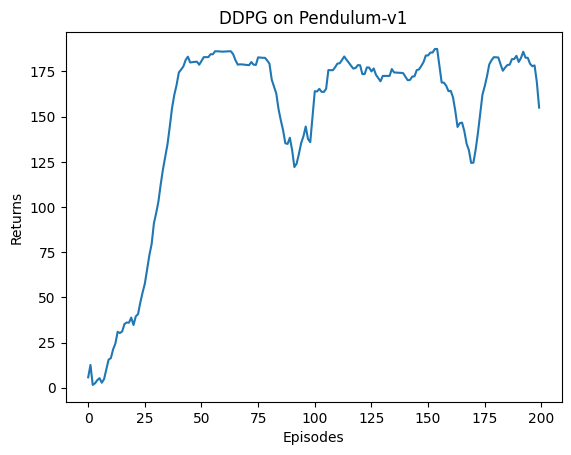

In [14]:
mv_return = utils.moving_average(return_list, 9)
utils.show_return(mv_return, agent, env)

# 再玩一局游戏（训练后）

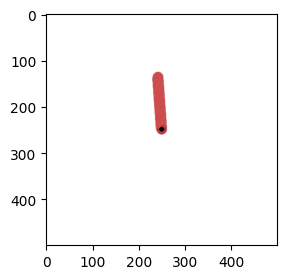

回报：183.40231921870668


In [15]:
episode_return = agent.play(env, update=False, show=True, replay_buffer=replay_buffer)
print("回报：{}".format(episode_return))